# Deep Learning Options Trading - Feature Analysis

This notebook analyzes the engineered features for **individual option contracts** from Databento:
- Feature importance and predictive power for option pricing
- Correlation with option prices (calls/puts from OHLCV data)
- Stationarity and time series properties
- Feature engineering validation

**Note:** Databento OHLCV schema provides individual contract data. Straddle construction happens at strategy execution, not in raw data.

In [3]:
import pandas as pd
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.stattools import adfuller
from pathlib import Path
import yaml
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [4]:
sys.path.append('..')
features_file = Path('../data/processed/features.csv')
if features_file.exists():
    print("Features already exist. Skipping feature engineering.")
    print(f"File: {features_file}")
    print(f"Size: {features_file.stat().st_size / 1024:.1f} KB")
else:
    print("Running feature engineering...")
    print("This will process raw options and underlying price data.\n")
    
    # Import and run the feature engineering module
    try:
        # Change to parent directory (where create_features.py expects to run from)
        original_dir = os.getcwd()
        parent_dir = Path('..').resolve()
        os.chdir(parent_dir)
        print(f"Changed working directory to: {os.getcwd()}")
        
        import create_features
        
        # Load raw data
        prices, options = create_features.load_raw_data()
        
        # Create features
        features = create_features.create_features(prices, options)
        
        # Create sequences for LSTM
        X, y, metadata = create_features.create_sequences(features, lookback_window=30)
        
        # Save everything
        output_file = create_features.save_processed_data(features, X, y, metadata)
        
        # Change back to original directory
        os.chdir(original_dir)
        
        print("\nSUCCESS - Feature engineering complete!")
        print(f"Features saved: {output_file}")
        print(f"  - Feature records: {len(features)}")
        print(f"  - Feature columns: {features.shape[1]}")
        print(f"  - LSTM sequences: {len(X)}")
        print(f"  - Sequence shape: {X.shape}")
        
    except Exception as e:
        # Make sure to change back to original directory on error
        if 'original_dir' in locals():
            os.chdir(original_dir)
        print(f"Error during feature engineering: {e}")
        import traceback
        traceback.print_exc()
        print("\nTip: Make sure you have run the data fetching notebook first.")

Features already exist. Skipping feature engineering.
File: ../data/processed/features.csv
Size: 371383.9 KB


## 1. Load Engineered Features

In [5]:
try:
    features_df = pd.read_csv('../data/processed/features.csv')
    features_df['date'] = pd.to_datetime(features_df['date'])
    print(f"Loaded features: {len(features_df)} records")
    print(f"Columns: {features_df.columns.tolist()}")
    
    # Separate features and target
    # Target is option_price (individual contracts, not straddles)
    feature_cols = [col for col in features_df.columns 
                   if col not in ['date', 'ticker', 'option_price', 'option_symbol']]
    
    target_col = 'option_price'
    X = features_df[feature_cols]
    y = features_df[target_col]
    
    print(f"\nFeatures ({len(feature_cols)}): {feature_cols}")
    print(f"Target: {target_col}")
    print(f"\nData shape: X={X.shape}, y={y.shape}")
except FileNotFoundError:
    print("Features not found. Run feature engineering first.")
    X, y = None, None

Loaded features: 2317424 records
Columns: ['date', 'ticker', 'option_price', 'option_volume', 'option_premium_normalized', 'underlying_price', 'underlying_return_1d', 'underlying_volatility_30d', 'option_symbol', 'option_price_ma5', 'option_price_std5', 'volume_ma5']

Features (8): ['option_volume', 'option_premium_normalized', 'underlying_price', 'underlying_return_1d', 'underlying_volatility_30d', 'option_price_ma5', 'option_price_std5', 'volume_ma5']
Target: option_price

Data shape: X=(2317424, 8), y=(2317424,)


In [ ]:
#investigate feature distributions and relationships with target 
features_df.tail(10)

## 2. Feature Correlation Analysis

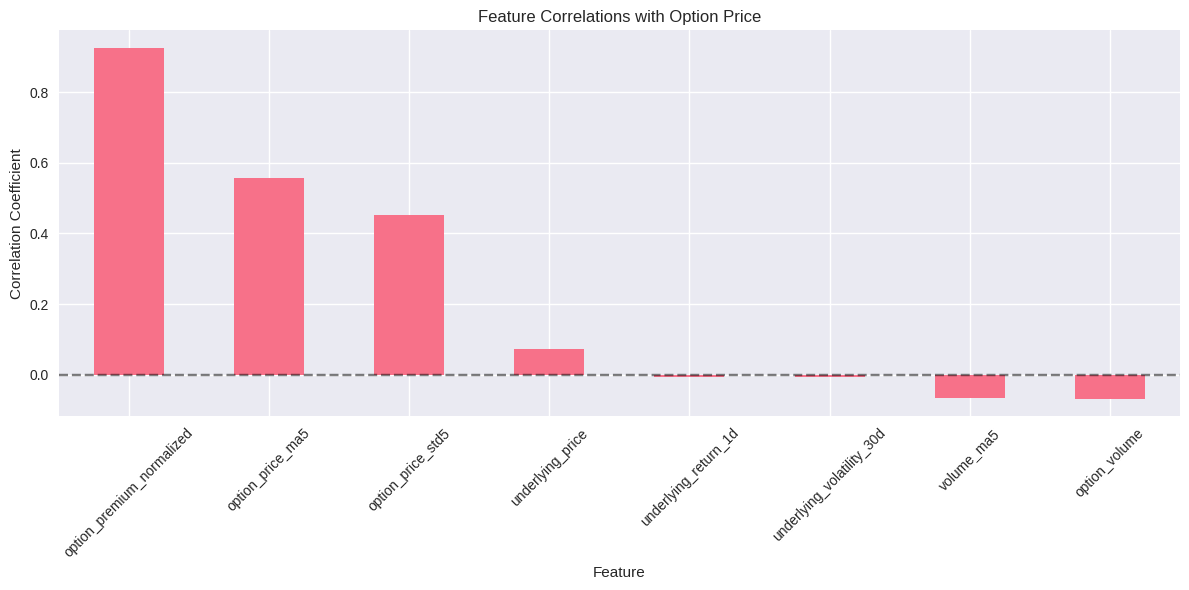

Top 5 positive correlations:
option_premium_normalized    0.925172
option_price_ma5             0.557810
option_price_std5            0.453023
underlying_price             0.073574
underlying_return_1d        -0.006018
dtype: float64

Top 5 negative correlations:
underlying_price             0.073574
underlying_return_1d        -0.006018
underlying_volatility_30d   -0.006153
volume_ma5                  -0.064147
option_volume               -0.068089
dtype: float64


In [6]:
if X is not None:
    # Correlation with target
    correlations = X.corrwith(y).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    correlations.plot(kind='bar')
    plt.title('Feature Correlations with Option Price')
    plt.xlabel('Feature')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print("Top 5 positive correlations:")
    print(correlations.head())
    print("\nTop 5 negative correlations:")
    print(correlations.tail())

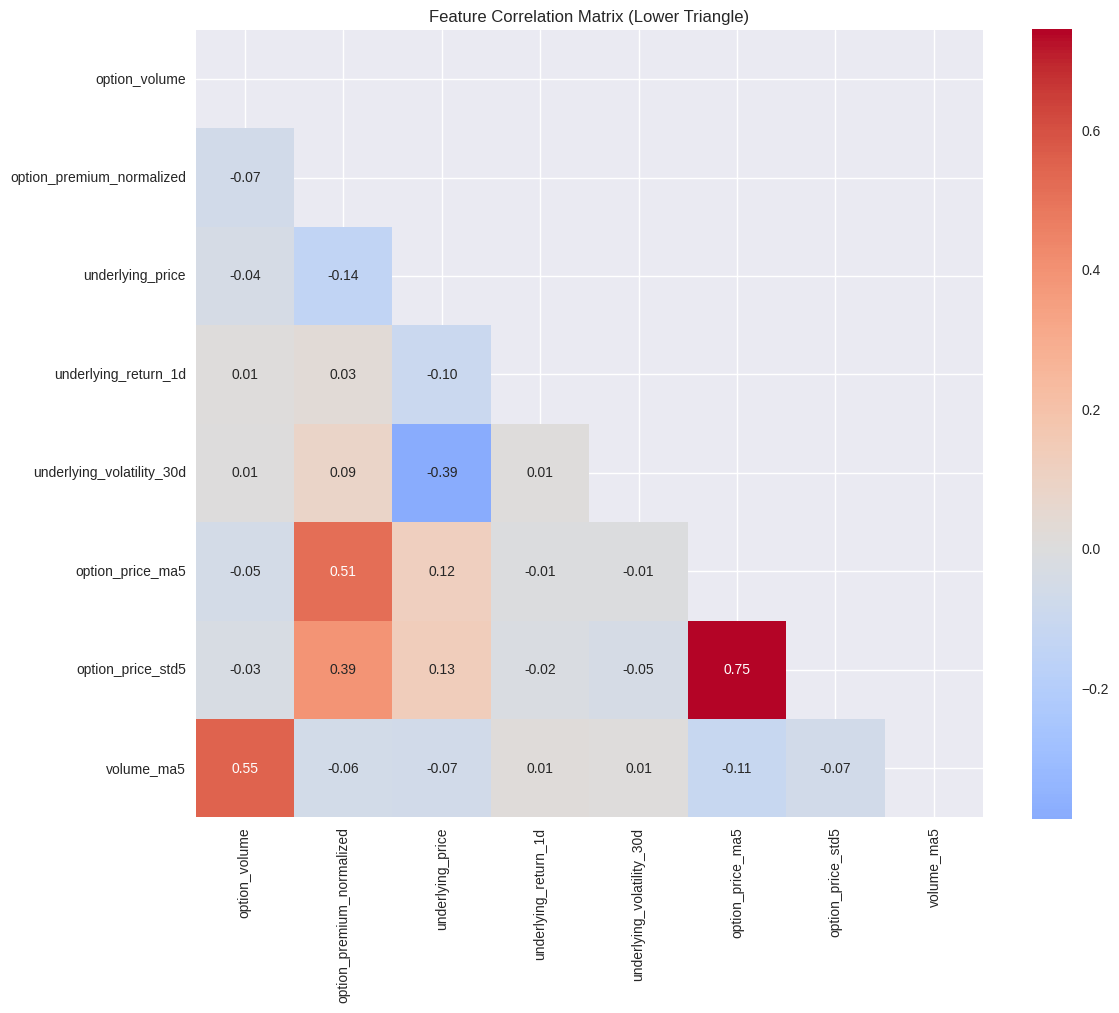

No highly correlated feature pairs found.


In [7]:
if X is not None:
    # Feature-to-feature correlations
    plt.figure(figsize=(12, 10))
    corr_matrix = X.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
    plt.title('Feature Correlation Matrix (Lower Triangle)')
    plt.tight_layout()
    plt.show()
    
    # Identify highly correlated features
    high_corr = np.where(np.abs(corr_matrix) > 0.8)
    high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                      for x, y in zip(*high_corr) if x != y and x < y]
    
    if high_corr_pairs:
        print("Highly correlated feature pairs (|corr| > 0.8):")
        for pair in high_corr_pairs:
            corr_value = corr_matrix.loc[pair[0], pair[1]]
            print(f"{pair[0]} - {pair[1]}: {corr_value:.3f}")
    else:
        print("No highly correlated feature pairs found.")

## 3. Feature Importance Analysis

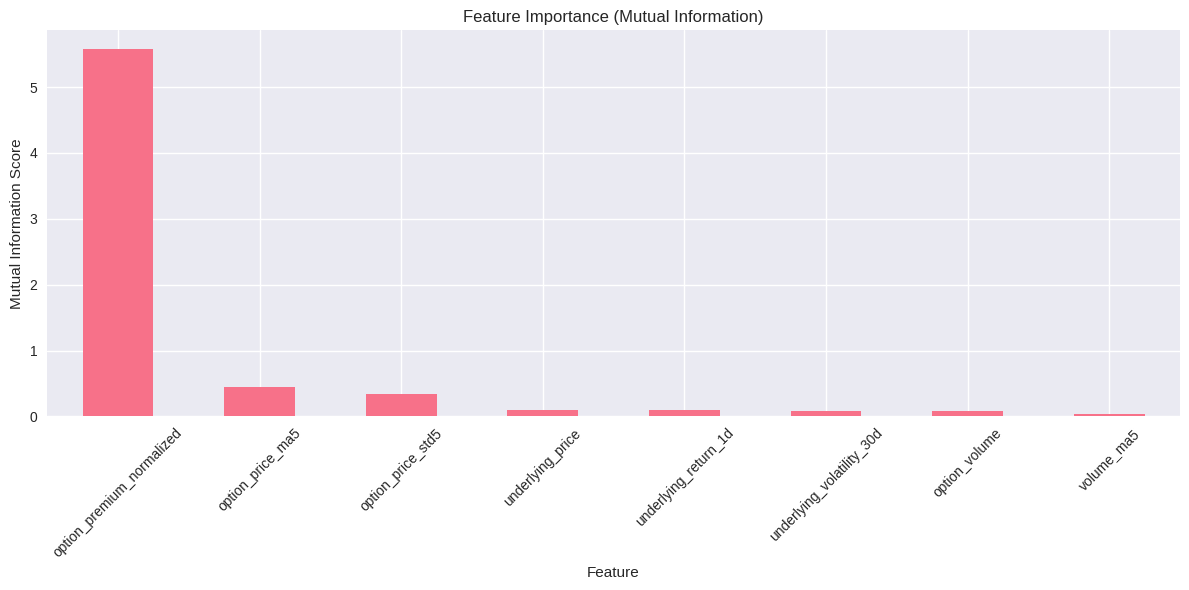

Mutual Information Scores:
option_premium_normalized: 5.5821
option_price_ma5: 0.4397
option_price_std5: 0.3471
underlying_price: 0.0985
underlying_return_1d: 0.0976
underlying_volatility_30d: 0.0891
option_volume: 0.0768
volume_ma5: 0.0389


In [8]:
if X is not None:
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    mi_scores.plot(kind='bar')
    plt.title('Feature Importance (Mutual Information)')
    plt.xlabel('Feature')
    plt.ylabel('Mutual Information Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("Mutual Information Scores:")
    for feature, score in mi_scores.items():
        print(f"{feature}: {score:.4f}")

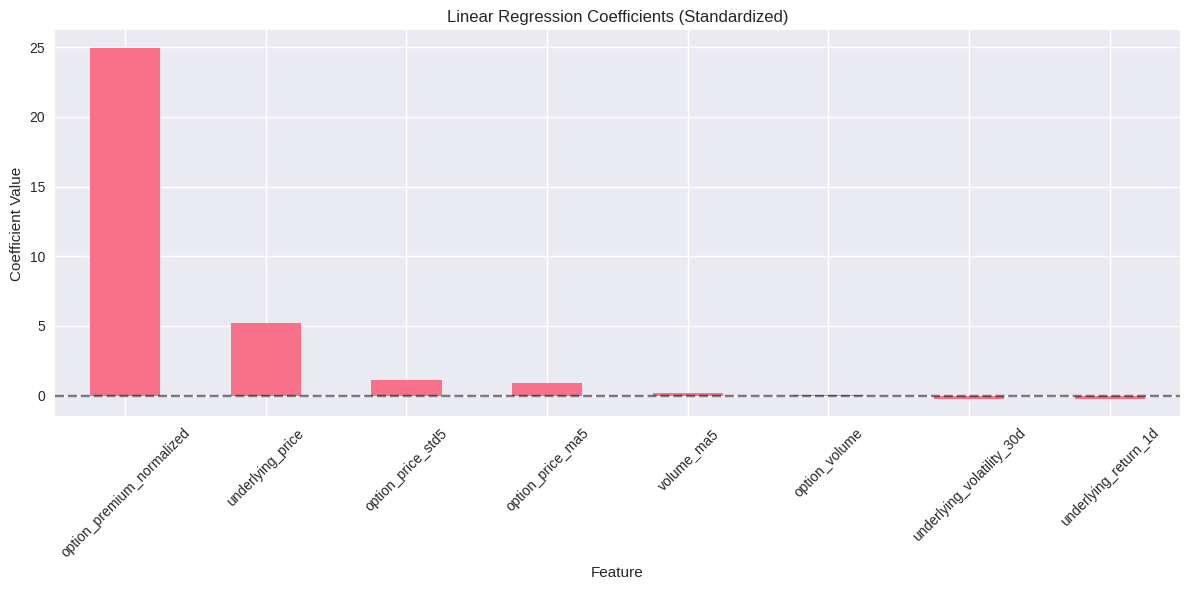

R² Score: 0.9031

Top positive coefficients:
option_premium_normalized    24.950345
underlying_price              5.223881
option_price_std5             1.137323
option_price_ma5              0.909201
volume_ma5                    0.207896
dtype: float64

Top negative coefficients:
option_price_ma5             0.909201
volume_ma5                   0.207896
option_volume                0.021599
underlying_volatility_30d   -0.207904
underlying_return_1d        -0.231739
dtype: float64


In [10]:
if X is not None:
    # Linear regression coefficients
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    lr = LinearRegression()
    lr.fit(X_scaled, y)
    
    # Get coefficients
    coefficients = pd.Series(lr.coef_, index=X.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    coefficients.plot(kind='bar')
    plt.title('Linear Regression Coefficients (Standardized)')
    plt.xlabel('Feature')
    plt.ylabel('Coefficient Value')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print(f"R² Score: {lr.score(X_scaled, y):.4f}")
    print("\nTop positive coefficients:")
    print(coefficients.head())
    print("\nTop negative coefficients:")
    print(coefficients.tail())

## 4. Stationarity Testing

In [14]:
if X is not None:
    # Augmented Dickey-Fuller test for stationarity
    print(f"Running stationarity tests on {len(X.columns)} features...")
    print(f"Dataset size: {len(X)} samples")
    
    # Sample large datasets to speed up ADF tests (use CONSECUTIVE samples for time series!)
    use_sampling = len(X) > 50000
    if use_sampling:
        sample_size = 50000
        # Take LAST 50k observations to preserve time series structure
        print(f"⚡ Using most recent {sample_size} observations for faster testing (preserves time structure)")
        X_sampled = X.iloc[-sample_size:]
    else:
        X_sampled = X
    
    print("This may take a moment...\n")
    
    # Option 1: Sequential (default) - Shows live progress
    USE_PARALLEL = True  # Set to True for 4-8x speedup on multi-core CPUs
    
    stationarity_results = {}
    
    if not USE_PARALLEL:
        # Sequential processing with live feedback
        for i, col in enumerate(X.columns, 1):
            print(f"Testing feature {i}/{len(X.columns)}: {col}...", end=' ')
            
            try:
                # Clean data
                data = X_sampled[col].dropna()
                
                # Skip if too few observations
                if len(data) < 10:
                    stationarity_results[col] = {'error': 'Insufficient data points (< 10)'}
                    print("Skipped (insufficient data)")
                    continue
                
                # Run ADF test
                adf_result = adfuller(data, maxlag=min(12, len(data)//5))
                
                stationarity_results[col] = {
                    'adf_statistic': adf_result[0],
                    'p_value': adf_result[1],
                    'critical_values': adf_result[4],
                    'stationary': adf_result[1] < 0.05
                }
                
                # Status indicator
                status = "✓ Stationary" if adf_result[1] < 0.05 else "✗ Non-stationary"
                print(f"{status} (p={adf_result[1]:.4f})")
                
            except ValueError as e:
                stationarity_results[col] = {'error': f'Value error: {str(e)}'}
                print(f"Error: {str(e)}")
            except Exception as e:
                stationarity_results[col] = {'error': f'Unexpected error: {str(e)[:50]}'}
                print(f"Error: {str(e)[:50]}")
    
    else:
        # Parallel processing - Faster but no live progress
        from multiprocessing import Pool, cpu_count
        import time
        
        def test_stationarity(args):
            col, data = args
            try:
                data_clean = data.dropna()
                if len(data_clean) < 10:
                    return (col, {'error': 'Insufficient data points (< 10)'})
                
                adf_result = adfuller(data_clean, maxlag=min(12, len(data_clean)//5))
                return (col, {
                    'adf_statistic': adf_result[0],
                    'p_value': adf_result[1],
                    'critical_values': adf_result[4],
                    'stationary': adf_result[1] < 0.05
                })
            except Exception as e:
                return (col, {'error': f'Error: {str(e)[:50]}'})
        
        n_cores = min(cpu_count(), len(X.columns))
        print(f"⚡ Using {n_cores} CPU cores for parallel testing...")
        
        start_time = time.time()
        with Pool(processes=n_cores) as pool:
            results = pool.map(test_stationarity, [(col, X_sampled[col]) for col in X.columns])
        
        stationarity_results = dict(results)
        elapsed = time.time() - start_time
        print(f"✓ Completed in {elapsed:.1f} seconds\n")
        
        # Display results after parallel completion
        for i, col in enumerate(X.columns, 1):
            result = stationarity_results[col]
            if 'error' not in result:
                status = "✓ Stationary" if result['stationary'] else "✗ Non-stationary"
                print(f"{i}. {col}: {status} (p={result['p_value']:.4f})")
            else:
                print(f"{i}. {col}:  {result['error']}")
    
    # Display detailed results
    print("\n" + "=" * 60)
    print("Stationarity Test Results (Augmented Dickey-Fuller):")
    print("=" * 60)
    
    for feature, result in stationarity_results.items():
        if 'error' not in result:
            print(f"\n{feature}:")
            print(f"  ADF Statistic: {result['adf_statistic']:.4f}")
            print(f"  p-value: {result['p_value']:.4f}")
            print(f"  Stationary: {result['stationary']}")
            print(f"  5% Critical Value: {result['critical_values']['5%']:.4f}")
        else:
            print(f"\n{feature}: {result['error']}")
    
    # Summary
    stationary_features = [f for f, r in stationarity_results.items() 
                          if 'stationary' in r and r['stationary']]
    non_stationary_features = [f for f, r in stationarity_results.items() 
                              if 'stationary' in r and not r['stationary']]
    error_features = [f for f, r in stationarity_results.items() if 'error' in r]
    
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    print(f"Stationary features: {len(stationary_features)}/{len(X.columns)}")
    print(f"Non-stationary features: {len(non_stationary_features)}/{len(X.columns)}")
    print(f"Errors: {len(error_features)}/{len(X.columns)}")
    
    if non_stationary_features:
        print(f"\nNon-stationary features: {', '.join(non_stationary_features)}")
        print("Consider differencing or other transformations for LSTM input.")
    
    if error_features:
        print(f"\nFeatures with errors: {', '.join(error_features)}")

Running stationarity tests on 8 features...
Dataset size: 2317424 samples
⚡ Using most recent 50000 observations for faster testing (preserves time structure)
This may take a moment...

⚡ Using 8 CPU cores for parallel testing...
✓ Completed in 3.8 seconds

1. option_volume: ✓ Stationary (p=0.0000)
2. option_premium_normalized: ✓ Stationary (p=0.0000)
3. underlying_price: ✗ Non-stationary (p=0.5008)
4. underlying_return_1d: ✗ Non-stationary (p=0.2380)
5. underlying_volatility_30d: ✗ Non-stationary (p=0.4196)
6. option_price_ma5: ✓ Stationary (p=0.0000)
7. option_price_std5: ✓ Stationary (p=0.0000)
8. volume_ma5: ✓ Stationary (p=0.0000)

Stationarity Test Results (Augmented Dickey-Fuller):

option_volume:
  ADF Statistic: -56.2122
  p-value: 0.0000
  Stationary: True
  5% Critical Value: -2.8616

option_premium_normalized:
  ADF Statistic: -44.4711
  p-value: 0.0000
  Stationary: True
  5% Critical Value: -2.8616

underlying_price:
  ADF Statistic: -1.5656
  p-value: 0.5008
  Stationary

## 5. Time Series Properties

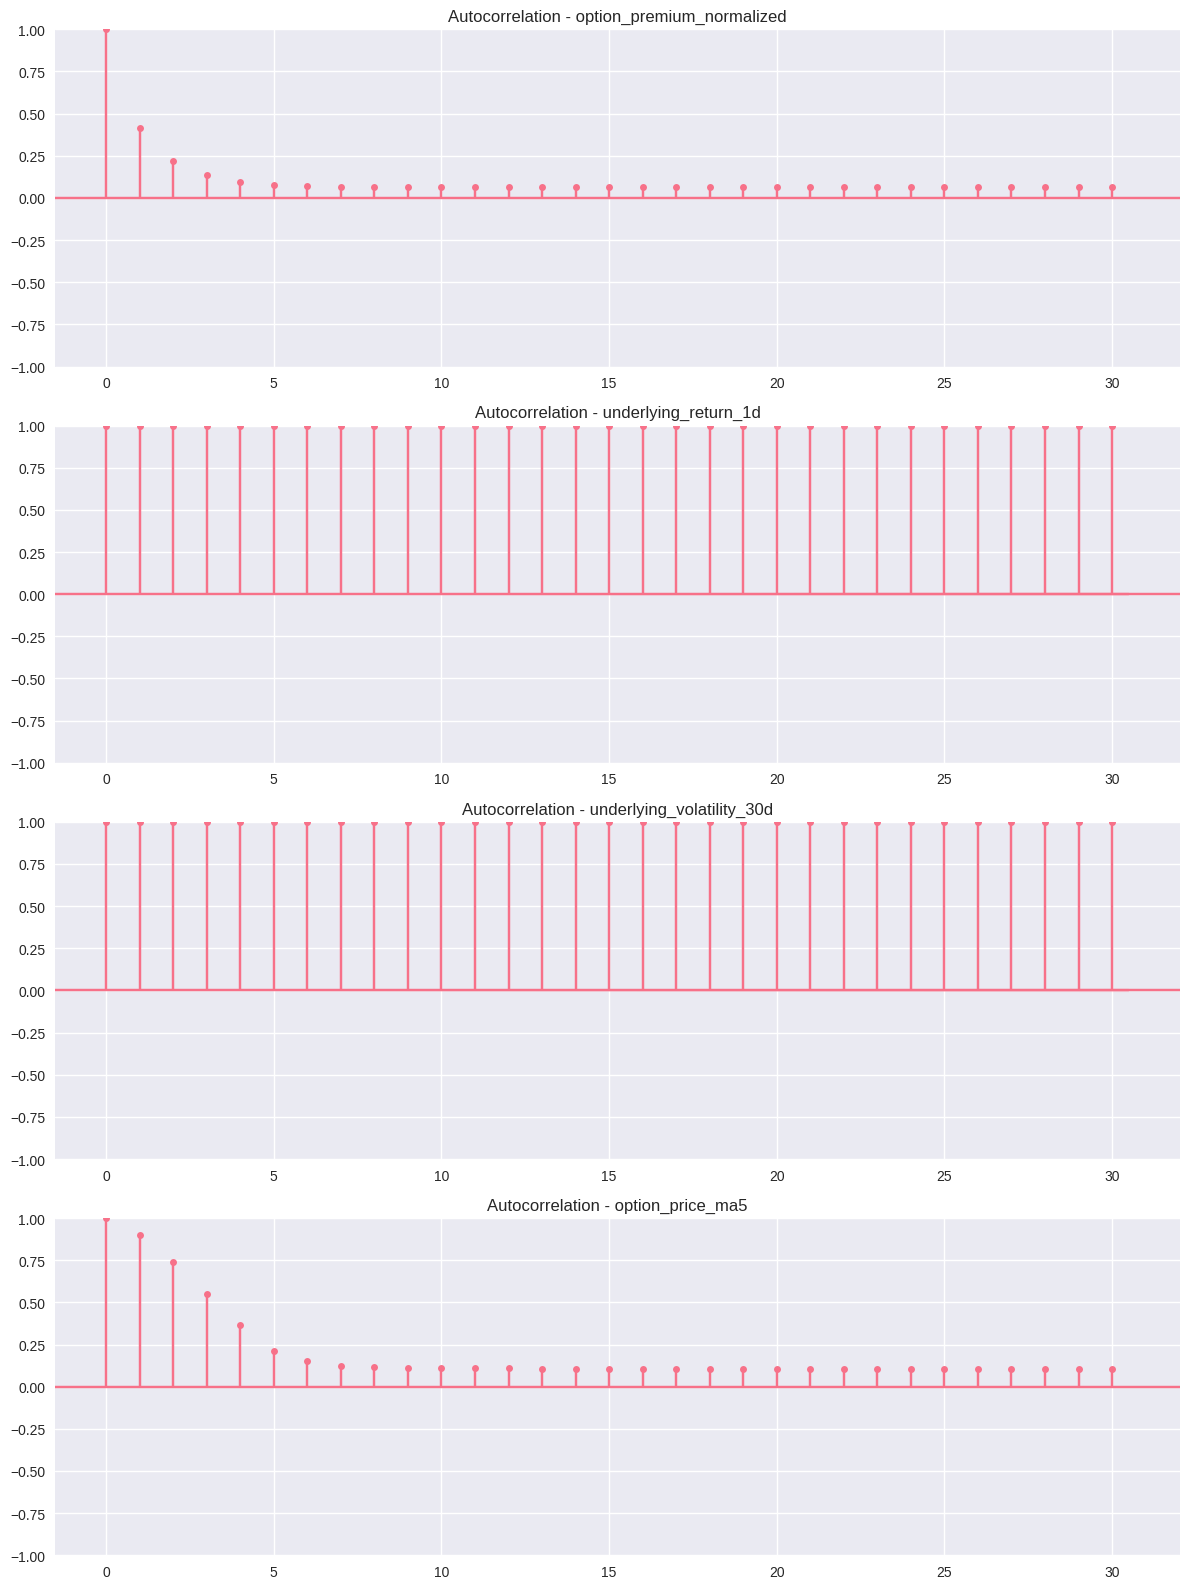

In [15]:
if X is not None:
    # Autocorrelation analysis for key features
    from statsmodels.graphics.tsaplots import plot_acf
    
    # Use features that actually exist in our data
    key_features = ['option_premium_normalized', 'underlying_return_1d', 'underlying_volatility_30d', 'option_price_ma5']
    key_features = [f for f in key_features if f in X.columns]
    
    fig, axes = plt.subplots(len(key_features), 1, figsize=(12, 4*len(key_features)))
    if len(key_features) == 1:
        axes = [axes]
    
    for i, feature in enumerate(key_features):
        plot_acf(X[feature].dropna(), lags=30, ax=axes[i], title=f'Autocorrelation - {feature}')
    
    plt.tight_layout()
    plt.show()

Plotting rolling statistics for top 5 features: option_premium_normalized, option_price_ma5, option_price_std5, underlying_price, option_volume


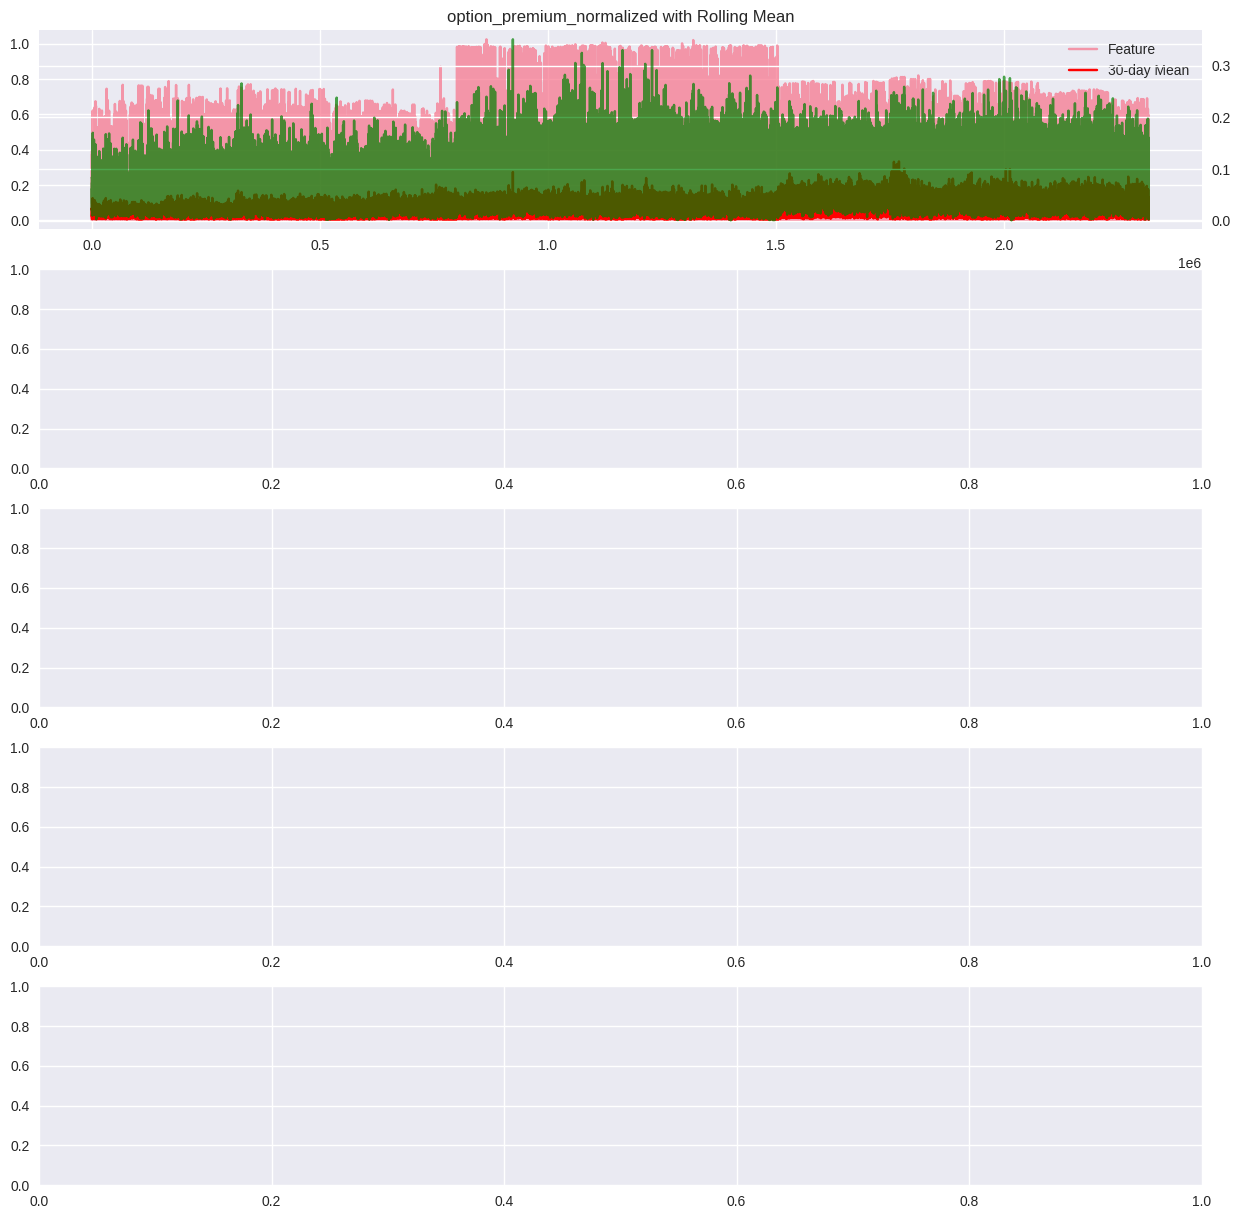

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

In [16]:
if X is not None:
    top_features = correlations.abs().nlargest(5).index.tolist()
    plot_features = [f for f in top_features if f in feature_cols]
    
    fig, axes = plt.subplots(len(plot_features), 1, figsize=(15, 3*len(plot_features)))
    if len(plot_features) == 1:
        axes = [axes]
    
    window = 30  # 30-day rolling window (adjust to 252 for full dataset)
    
    print(f"Plotting rolling statistics for top {len(plot_features)} features: {', '.join(plot_features)}")
    
    for i, feature in enumerate(plot_features):
        rolling_mean = X[feature].rolling(window=window).mean()
        rolling_std = X[feature].rolling(window=window).std()
        
        ax1 = axes[i]
        ax1.plot(X[feature].index, X[feature].values, alpha=0.7, label='Feature')
        ax1.plot(X[feature].index, rolling_mean, color='red', label=f'{window}-day Mean')
        ax1.set_title(f'{feature} with Rolling Mean')
        ax1.legend()
        
        # Add secondary y-axis for std
        ax2 = ax1.twinx()

        ax2.plot(X[feature].index, rolling_std, color='green', alpha=0.7, label=f'{window}-day Std')    
        plt.show()
        ax2.set_ylabel('Rolling Std', color='green')    
        plt.tight_layout()

        ax2.legend(loc='upper right')    

## 6. Feature Engineering Validation

Plotting box plots for top 5 features: option_premium_normalized, option_price_ma5, option_price_std5, underlying_price, option_volume


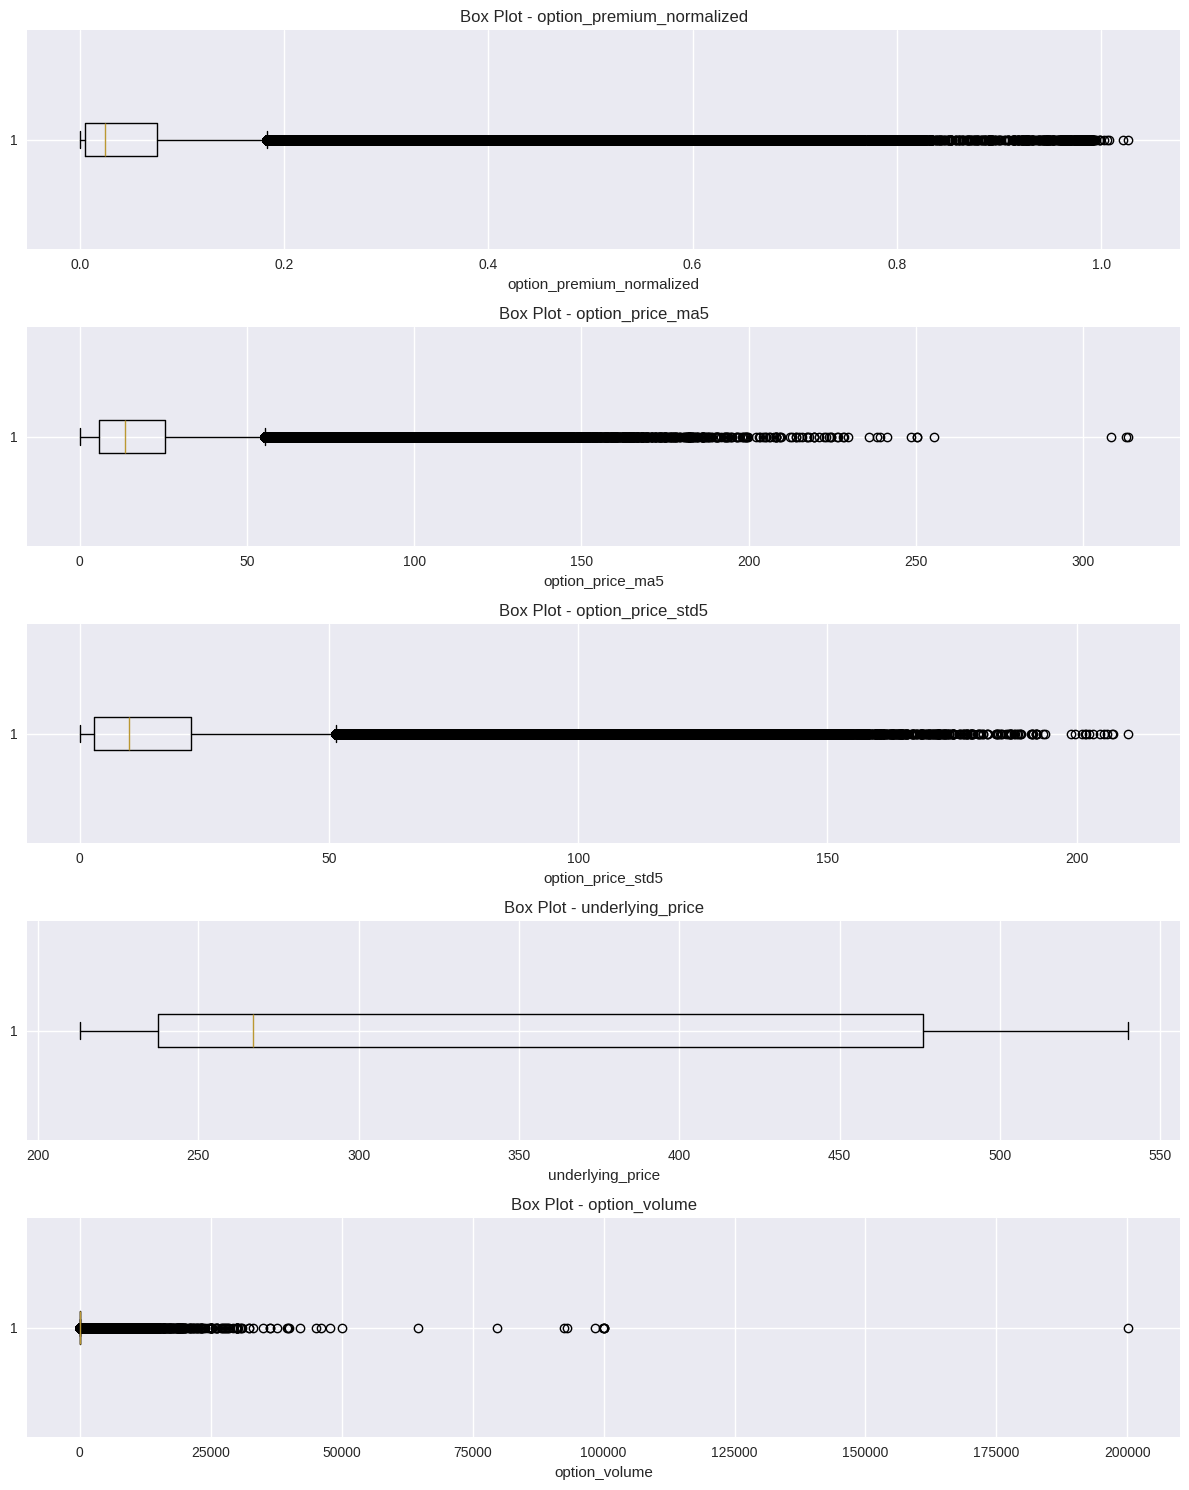


Outlier Analysis:
option_volume: 336914 outliers (14.54%)
option_premium_normalized: 193391 outliers (8.35%)
underlying_price: 0 outliers (0.00%)
underlying_return_1d: 181260 outliers (7.82%)
underlying_volatility_30d: 197283 outliers (8.51%)
option_price_ma5: 88393 outliers (3.81%)
option_price_std5: 107215 outliers (4.63%)
volume_ma5: 292617 outliers (12.63%)


In [19]:
if X is not None:
    # Check for outliers
    # Only plot top 5 features by correlation to prevent memory issues
    top_features = correlations.abs().nlargest(5).index.tolist()
    plot_features = [f for f in top_features if f in feature_cols]
    
    fig, axes = plt.subplots(len(plot_features), 1, figsize=(12, 3*len(plot_features)))
    if len(plot_features) == 1:
        axes = [axes]
    
    print(f"Plotting box plots for top {len(plot_features)} features: {', '.join(plot_features)}")
    
    for i, feature in enumerate(plot_features):
        # Box plot for outlier detection
        axes[i].boxplot(X[feature].dropna(), vert=False)
        axes[i].set_title(f'Box Plot - {feature}')
        axes[i].set_xlabel(feature)
    
    plt.tight_layout()
    plt.show()
    
    # Outlier statistics
    print("\nOutlier Analysis:")
    outlier_stats = {}
    for feature in feature_cols:
        data = X[feature].dropna()
        q1, q3 = data.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_stats[feature] = {
            'outlier_count': len(outliers),
            'outlier_percentage': len(outliers) / len(data) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
    
    # Print outlier statistics
    for feature, stats in outlier_stats.items():
        print(f"{feature}: {stats['outlier_count']} outliers ({stats['outlier_percentage']:.2f}%)")

## 7. Feature Analysis Summary

In [20]:
# Generate comprehensive feature analysis report
if X is not None:
    print("=== FEATURE ANALYSIS SUMMARY ===\n")
    
    # Feature overview
    print(f"Total features: {len(feature_cols)}")
    print(f"Total samples: {len(X)}")
    print(f"Missing values: {X.isnull().sum().sum()}")
    
    # Predictive power ranking
    print("\nTop 5 features by correlation with target:")
    top_corr = correlations.head()
    for i, (feature, corr) in enumerate(top_corr.items(), 1):
        print(f"{i}. {feature}: {corr:.4f}")
    
    print("\nTop 5 features by mutual information:")
    top_mi = mi_scores.head()
    for i, (feature, mi) in enumerate(top_mi.items(), 1):
        print(f"{i}. {feature}: {mi:.4f}")
    
    # Stationarity summary
    stationary_count = sum(1 for r in stationarity_results.values() if r.get('stationary', False))
    print(f"\nStationary features: {stationary_count}/{len(feature_cols)}")
    
    # Data quality
    total_outliers = sum(stats['outlier_count'] for stats in outlier_stats.values())
    avg_outlier_pct = np.mean([stats['outlier_percentage'] for stats in outlier_stats.values()])
    print(f"Total outliers: {total_outliers}")
    print(f"Average outlier percentage: {avg_outlier_pct:.2f}%")
    
    # Recommendations
    print("\n=== RECOMMENDATIONS ===")
    
    if non_stationary_features:
        print(f"Consider differencing for non-stationary features: {', '.join(non_stationary_features[:3])}...")
    
    if avg_outlier_pct > 5:
        print("High outlier percentage detected. Consider robust scaling or outlier treatment.")
    
    low_corr_features = correlations[correlations.abs() < 0.1]
    if len(low_corr_features) > 0:
        print(f"Consider removing low-correlation features: {', '.join(low_corr_features.index[:3])}...")
    
    print("\n=== ANALYSIS COMPLETE ===")
else:
    print("Features not available for analysis. Run feature engineering first.")

=== FEATURE ANALYSIS SUMMARY ===

Total features: 8
Total samples: 2317424
Missing values: 0

Top 5 features by correlation with target:
1. option_premium_normalized: 0.9252
2. option_price_ma5: 0.5578
3. option_price_std5: 0.4530
4. underlying_price: 0.0736
5. underlying_return_1d: -0.0060

Top 5 features by mutual information:
1. option_premium_normalized: 5.5821
2. option_price_ma5: 0.4397
3. option_price_std5: 0.3471
4. underlying_price: 0.0985
5. underlying_return_1d: 0.0976

Stationary features: 5/8
Total outliers: 1397073
Average outlier percentage: 7.54%

=== RECOMMENDATIONS ===
Consider differencing for non-stationary features: underlying_price, underlying_return_1d, underlying_volatility_30d...
High outlier percentage detected. Consider robust scaling or outlier treatment.
Consider removing low-correlation features: underlying_price, underlying_return_1d, underlying_volatility_30d...

=== ANALYSIS COMPLETE ===
